In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
dataset_path = "../tf/"
print(os.listdir(dataset_path))

['tensorflow-tutorials', 'BLDC fan motor anomaly detection using Bi-LSTM.ipynb', 'DC voltage from normal BLDC motor .csv', '3000시퀀스씩.ipynb', 'BLDC_fan_motor_LSTM_AE_model.ipynb', 'DC voltage from fault BLDC motor.csv', 'Untitled.ipynb', 'BLDC_fan_motor_LSTM_VAE_model.ipynb', '.ipynb_checkpoints', 'dataset.csv', 'BLDC fan motor anomaly detection(Gaussian) using Bi-LSTM.ipynb']


In [3]:
Normal = []
Fault = []
for files in os.listdir(dataset_path):
    if 'normal' in files:
        Fault.append(pd.read_csv(os.path.join(dataset_path, files)))
    elif  'fault' in files:
        Normal.append(pd.read_csv(os.path.join(dataset_path, files)))

In [4]:
Normal_data = pd.concat(Fault)
Fault_data = pd.concat(Normal)

# 1. LPF

In [5]:
from scipy import signal
from scipy.io import wavfile

sr = len(Normal_data)
normal_data_ampl=Normal_data['Ampl']
LPF_noraml=signal.firwin(101, cutoff=400, fs=sr, pass_zero='lowpass')
normal_data_ampl_lpf=signal.lfilter(LPF_noraml, [1.0], normal_data_ampl)

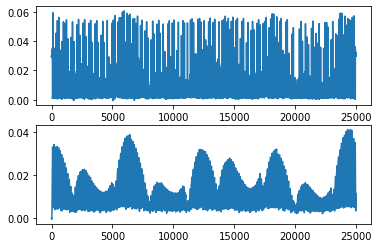

In [6]:
plt.subplot(2,1,1)
plt.plot(Normal_data['Ampl'])
plt.subplot(2,1,2)
plt.plot(normal_data_ampl_lpf)

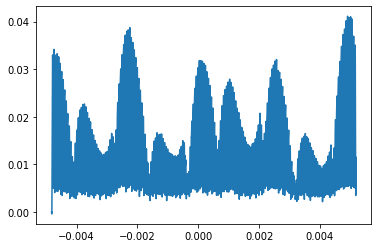

In [78]:
plt.plot(Normal_data['Time'],normal_data_ampl_lpf)

In [88]:
x = X_train[0:240]
y = y_train[0:240]

In [83]:
x_pred=bi_lstm_model.predict(x)

In [84]:
x_pred=x_pred.reshape(24000)

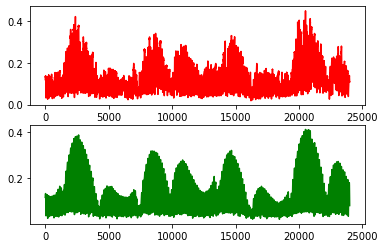

In [90]:
plt.subplot(2,1,1)
plt.plot(x_pred,'r')
plt.subplot(2,1,2)
plt.plot(y,'g')

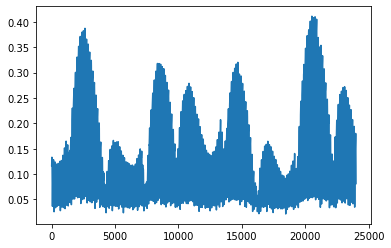

In [89]:
y=y.reshape(24000)
plt.plot(y)

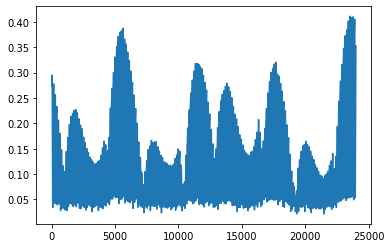

In [87]:
x=x.reshape(24000)
plt.plot(x)

# 2. Reshape


In [29]:
train = normal_data_ampl_lpf[0:22000]*10
train = train.reshape(220, 100, 1).astype(np.float64)
after_train = normal_data_ampl_lpf[3000:25000]

In [8]:
y_train = X_train[10:220]
X_train = X_train[0:210]

NameError: name 'X_train' is not defined

# 3.1 Bi-LSTM Model
--> 500 시퀸스씩 입력하면 가장 비슷한 패턴을 가짐

In [9]:
import random
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation

from keras.layers.recurrent import LSTM
from keras.layers import Input, LSTM, RepeatVector, Masking, TimeDistributed, Lambda
from keras.losses import mse, binary_crossentropy, mean_squared_error
from keras.models import Model
from keras import backend as K

In [10]:
TIME_STEPS = 100
input_shape = (None, TIME_STEPS , 1)  # train_size, time_steps, number_of_feature

bi_lstm_model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(
                32,
            )
        ),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(TIME_STEPS, activation="sigmoid"),
    ]
)

bi_lstm_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[
        #tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        #tf.keras.metrics.AUC(),
    ],
)


bi_lstm_model.build(input_shape)
bi_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 100, 128)          33792     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               6500      
Total params: 98,084
Trainable params: 98,084
Non-trainable params: 0
_________________________________________________________________


In [11]:
datas=pd.read_csv(os.path.join(dataset_path, 'dataset.csv'))

In [12]:
X = datas['Ampl']*10

In [13]:
X.shape

(775052,)

In [80]:
X = X[0:775000]
X = np.array(X)
X = X.reshape((7750,100,1))

In [15]:
X.shape

(7750, 100, 1)

In [81]:
X_train = X[0:7720]
y_train = X[30:7750]

In [25]:
history = bi_lstm_model.fit(
    X_train,
    y_train,
    batch_size=25,
    epochs=50,
    validation_split=0.2
)

Epoch 1/50
248/248 [==============================] - 4s 17ms/step - loss: 0.4035 - precision: 1.0000 - recall: 9.7150e-05 - val_loss: 0.4076 - val_precision: 1.0000 - val_recall: 3.6269e-04
Epoch 2/50
164/248 [==================>...........] - ETA: 1s - loss: 0.4014 - precision: 1.0000 - recall: 2.7805e-04

KeyboardInterrupt: 

# 3000 시퀀스 이후 탐지

In [26]:
yhat=bi_lstm_model.predict(train)
yhat=yhat.reshape((220,100,1))
train=train.reshape((22000,1))
yhat=yhat.reshape((22000,1))
#y_train=y_train.reshape((21000,1))
#Square_error = (np.square(y_train - yhat))
#mse_train = np.mean(np.power(yhat - y_train, 2), axis=1)

Text(0, 0.5, 'Predictions-Volteges')

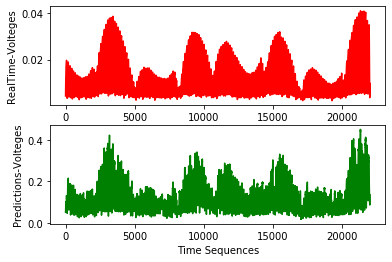

In [30]:
plt.subplot(2,1,1)
plt.plot(after_train,'r')
plt.ylabel("RealTime-Volteges")
plt.subplot(2,1,2)
plt.plot(yhat,'g') # 예측 데이터
plt.xlabel("Time Sequences")
plt.ylabel("Predictions-Volteges")
#plt.subplot(2,2,3)
#plt.plot(Square_error)
#plt.xlabel("Time Sequences")
#plt.ylabel("Square_error")
#plt.subplot(2,2,4)
#plt.plot(mse_train,'y')
#plt.xlabel("Time Sequences")
#plt.ylabel("MSE")

# 3.1.2 확률밀도함수 / Train dataset 신뢰도 분포 계산

In [33]:
yhat_=bi_lstm_model.predict(X_train)
yhat_=yhat_.reshape((7720,100,1))
mse = np.mean(np.power(y_train -yhat_, 2), axis=1)

In [93]:
y_pred_mean=np.mean(mse)
y_pred_std=np.std(mse)
print(y_pred_mean, y_pred_std)

0.0012255440542715975 0.004642448327113399


In [36]:
from scipy.stats import norm
rv = norm(loc = y_pred_mean, scale = y_pred_std)

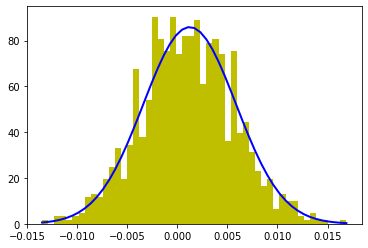

In [37]:
s = np.random.normal(y_pred_mean, y_pred_std, 1000)
count, bins, ignored = plt.hist(s, 50, density=True, color='y')
plt.plot(bins, 1/(y_pred_std * np.sqrt(2 * np.pi)) *
         np.exp( - (bins - y_pred_mean)**2 / (2 * y_pred_std**2) ),
         linewidth=2, color='b')
plt.show()

In [38]:
train_proba_function = 1/(y_pred_std * np.sqrt(2 * np.pi)) * np.exp( - (bins - y_pred_mean)**2 / (2 * y_pred_std**2) )

In [69]:
import scipy.stats as st
st.t.interval(0.95, len(yhat_)-1, loc=y_pred_mean, scale=y_pred_std)

(-0.007874914445109266, 0.010326002553652461)

MSE의 Confidence 93% 구간 = [-0.14048 ~ 0.14171]

# 3.2 Validation

In [48]:
x_valid_set = normal_data_ampl_lpf[2000:15000]*10
x_valid_set = x_valid_set.reshape(130, 100, 1).astype(np.float64)

y_valid_set = normal_data_ampl_lpf[5000:18000]*10
y_valid_set = y_valid_set.reshape(130, 100, 1).astype(np.float64)

yhat_val=bi_lstm_model.predict(x_valid_set)
yhat_val=yhat_val.reshape(130, 100, 1).astype(np.float64)

Text(0, 0.5, 'Input')

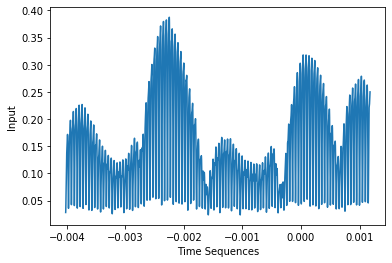

In [75]:
x_valid_set = x_valid_set.reshape(13000)
plt.plot(Normal_data['Time'][2000:15000],x_valid_set)
plt.xlabel("Time Sequences")
plt.ylabel("Input")

Text(0.5, 0, 'Time Sequences')

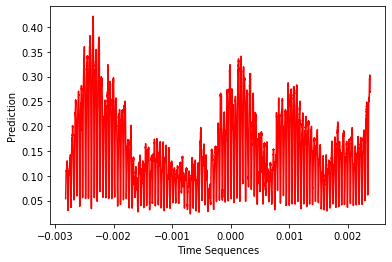

In [76]:
plt.plot(Normal_data['Time'][5000:18000],yhat_val,'r')
plt.ylabel("Prediction")
plt.xlabel("Time Sequences")

Text(0, 0.5, 'Real-time data')

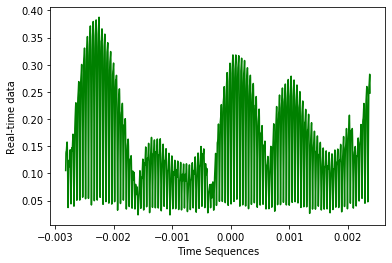

In [77]:
plt.plot(Normal_data['Time'][5000:18000],y_valid_set,'g')
plt.xlabel("Time Sequences")
plt.ylabel("Real-time data")

# nomal dataset 신뢰도 분포 계산

In [49]:
mse_valid = np.mean(np.power(y_valid_set -yhat_val, 2), axis=1)

In [70]:
for i in range(len(mse_valid)):
    if mse_valid[i]>0.010326 or mse_valid[i]<-0.00787:
        print(str(i)+"번째 Anomaly 감지")


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


Text(0, 0.5, 'Real-time data')

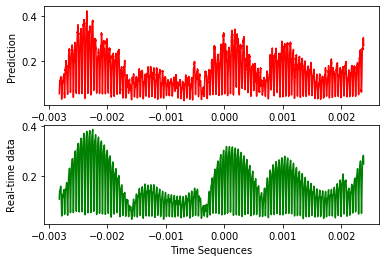

In [73]:
yhat_val = yhat_val.reshape(13000)
y_valid_set = y_valid_set.reshape(13000)
plt.subplot(2,1,1)
plt.plot(Normal_data['Time'][5000:18000],yhat_val,'r')
plt.ylabel("Prediction")
plt.xlabel("Time Sequences")
plt.subplot(2,1,2)
plt.plot(Normal_data['Time'][5000:18000],y_valid_set,'g')
plt.xlabel("Time Sequences")
plt.ylabel("Real-time data")

In [92]:
y_val_mean=np.mean(mse_valid)
y_val_std=np.std(mse_valid)
print(y_val_mean, y_val_std)

0.000627210612067715 0.0010807993073792713


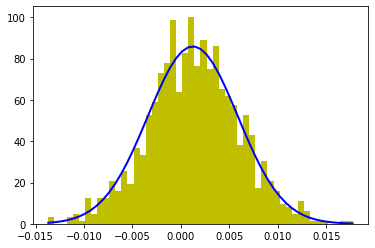

In [104]:
s = np.random.normal(y_pred_mean, y_pred_std, 1000)
s2 = np.random.normal(y_val_mean, y_val_std, 1000)
count, bins, ignored = plt.hist(s, 50, density=True, color='y')
plt.plot(bins, 1/(y_pred_std * np.sqrt(2 * np.pi)) *
         np.exp( - (bins - y_pred_mean)**2 / (2 * y_pred_std**2) ),
         linewidth=2, color='b')

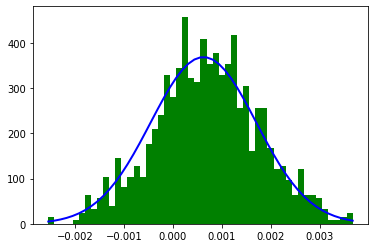

In [106]:
count2, bins2, ignored2 = plt.hist(s2, 50, density=True, color='g')
plt.plot(bins2, 1/(y_val_std * np.sqrt(2 * np.pi)) *
         np.exp( - (bins2 - y_val_mean)**2 / (2 * y_val_std**2) ),
         linewidth=2, color='b')

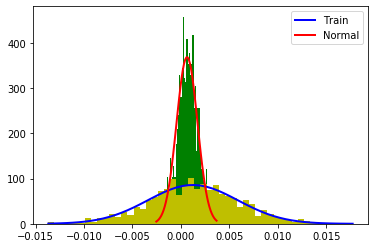

In [128]:
plt.plot(bins, 1/(y_pred_std * np.sqrt(2 * np.pi)) *
         np.exp( - (bins - y_pred_mean)**2 / (2 * y_pred_std**2) ),
         linewidth=2, color='b', label = "Train")
plt.hist(s2, 50, density=True, color='g')
plt.hist(s, 50, density=True, color='y')
plt.plot(bins2, 1/(y_val_std * np.sqrt(2 * np.pi)) *
         np.exp( - (bins2 - y_val_mean)**2 / (2 * y_val_std**2) ),
         linewidth=2, color='r', label = "Normal")
plt.legend()

In [109]:
st.t.interval(0.95, len(mse_valid)-1, loc=y_val_mean, scale=y_val_std)

(-0.0015111772879336702, 0.0027655985120691004)

# 4. test

In [52]:
sr_test = len(Fault_data)
fault_data_ampl=Fault_data['Ampl']
LPF_fault=signal.firwin(101, cutoff=400, fs=sr_test, pass_zero='lowpass')
fault_data_ampl_lpf=signal.lfilter(LPF_fault, [1.0], fault_data_ampl)

In [53]:
X_test = fault_data_ampl_lpf[0:22000]
y_test = fault_data_ampl_lpf[3000:25000]
X_test = np.array(X_test)*10
y_test = np.array(y_test)*10

X_test = X_test.reshape(220, 100, 1).astype(np.float64)
print("Training data shapes : ", X_test.shape)

y_test = y_test.reshape(220, 100, 1).astype(np.float64)
print("label data shapes : ", X_test.shape)

Training data shapes :  (220, 100, 1)
label data shapes :  (220, 100, 1)


In [54]:
y_test_predict=bi_lstm_model.predict(X_test)

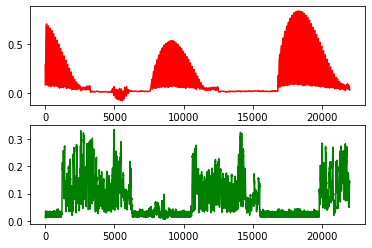

In [110]:
X_test=X_test.reshape((22000))
y_test_predict=y_test_predict.reshape((22000))
y_test=y_test.reshape((22000))
plt.subplot(2,1,1)
plt.plot(y_test,'r')
plt.subplot(2,1,2)
plt.plot(y_test_predict,'g') # 예측 데이터

In [57]:
y_test_predict = y_test_predict.reshape((220,100,1))
y_test=y_test.reshape((220,100,1))
mse_test = np.mean(np.power(y_test_predict - y_test, 2), axis=1)

Text(0.5, 0, 'Time Sequences')

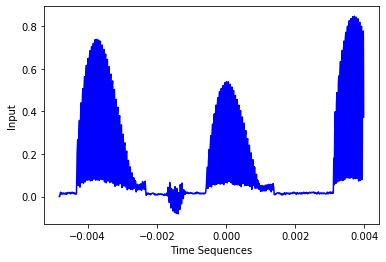

In [114]:
plt.plot(Fault_data['Time'][0:22000],X_test,'b')
plt.ylabel("Input")
plt.xlabel("Time Sequences")

Text(0, 0.5, 'Real-time data')

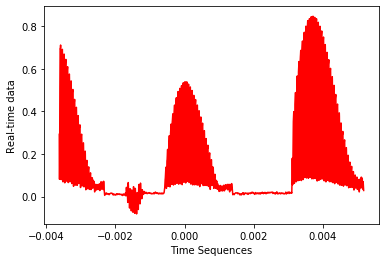

In [117]:
plt.plot(Fault_data['Time'][3000:25000],y_test,'r')
plt.xlabel("Time Sequences")
plt.ylabel("Real-time data")

Text(0.5, 0, 'Time Sequences')

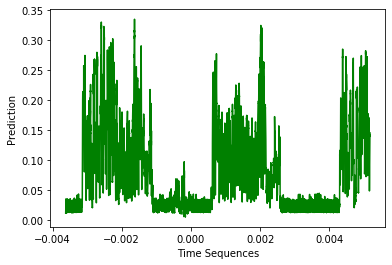

In [116]:
plt.plot(Fault_data['Time'][3000:25000],y_test_predict,'g')
plt.ylabel("Prediction")
plt.xlabel("Time Sequences")

# Anomaly dataset 신뢰도 분포 계산

In [118]:
y_test = y_test.reshape((220,100,1))
y_test_predict = y_test_predict.reshape((220,100,1))
mse_test = np.mean(np.power(y_test_predict - y_test, 2), axis=1)
y_test_mean=np.mean(mse_test)
y_test_std=np.std(mse_test)
print(y_test_mean, y_test_std)

0.0696866418260961 0.10446653586125648


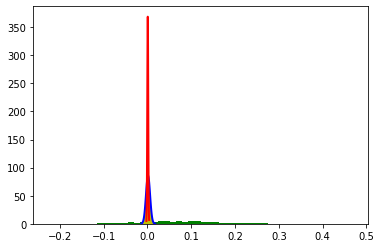

In [119]:
s3 = np.random.normal(y_test_mean, y_test_std, 1000)
plt.plot(bins, 1/(y_pred_std * np.sqrt(2 * np.pi)) *
         np.exp( - (bins - y_pred_mean)**2 / (2 * y_pred_std**2) ),
         linewidth=2, color='b')
count3, bins3, ignored3 = plt.hist(s3, 50, density=True, color='g')
plt.hist(s, 50, density=True, color='y')
plt.plot(bins2, 1/(y_val_std * np.sqrt(2 * np.pi)) *
         np.exp( - (bins2 - y_val_mean)**2 / (2 * y_val_std**2) ),
         linewidth=2, color='r')

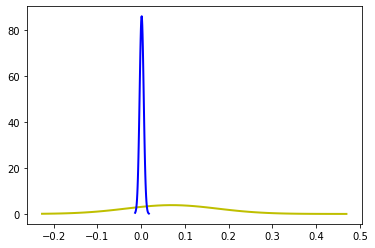

In [121]:
plt.plot(bins3, 1/(y_test_std * np.sqrt(2 * np.pi)) *
         np.exp( - (bins3 - y_test_mean)**2 / (2 * y_test_std**2) ),
         linewidth=2, color='y')
plt.plot(bins, 1/(y_pred_std * np.sqrt(2 * np.pi)) *
         np.exp( - (bins - y_pred_mean)**2 / (2 * y_pred_std**2) ),
         linewidth=2, color='b', label = "Train")

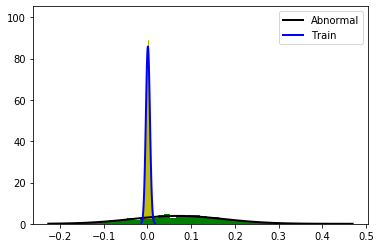

In [129]:
plt.hist(s, 50, density=True, color='y')
plt.hist(s3, 50, density=True, color='g')
plt.plot(bins3, 1/(y_test_std * np.sqrt(2 * np.pi)) *
         np.exp( - (bins3 - y_test_mean)**2 / (2 * y_test_std**2) ),
         linewidth=2, color='k',label = "Abnormal")
plt.plot(bins, 1/(y_pred_std * np.sqrt(2 * np.pi)) *
         np.exp( - (bins - y_pred_mean)**2 / (2 * y_pred_std**2) ),
         linewidth=2, color='b',label = "Train")
plt.legend()

In [124]:
st.t.interval(0.95, len(mse_test)-1, loc=y_test_mean, scale=y_test_std)

(-0.13620179106446603, 0.2755750747166582)